# Algoritmos de optimización - Trabajo Práctico<br>
Nombre y Apellidos: Martin Gonzalez Vergara  <br>
Url: https://github.com/.../03MAIR---Algoritmos-de-Optimizacion---/tree/master/TrabajoPractico<br>
Google Colab: https://colab.research.google.com/drive/xxxxxxxxxxxxxxxx <br>
Problema: Organizar los horarios de partidos de La Liga



Descripción del problema:

Desde la La Liga de fútbol profesional se pretende organizar los horarios de los partidos de
liga de cada jornada. Se conocen algunos datos que nos deben llevar a diseñar un
algoritmo que realice la asignación de los partidos a los horarios de forma que maximice la
audiencia.
• Los horarios disponibles se conocen a priori y son los siguientes:
| Día     | Horario     |
|---------|-------------|
| Viernes | 20          |       
| Sábado  | 12,16,18,20 |           
| Domingo | 12,16,18,20 |            
| Lunes   | 20          |  




En primer lugar se clasifican los equipos en tres categorías según el numero de
seguidores( que tiene relación directa con la audiencia). Hay 3 equipos en la
categoría A, 11 equipos de categoría B y 6 equipos de categoría C.
• Se conoce estadísticamente la audiencia que genera cada partido según los equipos
que se enfrentan y en horario de sábado a las 20h (el mejor en todos los casos)
|                   | Categoría A | Categoría B   | Categoría C   |
|-------------------|-------------|---------------|---------------|
| Categoría A       | 2 millones  | 1,3 millones  | 1 millones    |
| Categoría B       |             | 0,9 millones  | 0,75 millones |
| Categoría C       |             |               | 0,47 millones |


Si el horario del partido no se realiza a las 20 horas del sábado se sabe que se reduce
según los coeficientes de la siguiente tabla
• Debemos asignar obligatoriamente siempre un partido el viernes y un partido el lunes
|      | Viernes |  Sábado   | Domingo   | Lunes   |
|------|---------|-----------|-----------|---------|
| 12h  |         | 0,55      | 0,45      |         |
| 16h  |         | 0,7       | 0,75      |         |
| 18h  |         | 0,8       | 0,85      |         |
| 20h  |0,4      | 1         | 1         |0,4      |

Es posible la coincidencia de horarios pero en este
caso la audiencia de cada partido se verá afectada y
se estima que se reduce en porcentaje según la
siguiente tabla dependiendo del número de
coincidencias

| Coincidencias| -%  |
|--------------|-----|
| 0            |  0% |
| 1            | 25% |
| 2            | 45% |
| 3            | 60% |
| 4            | 70% |
| 5            | 75% |
| 6            | 78% |
| 7            | 80% |
| 8            | 80% |                                        

#Modelo
- ¿Como represento el espacio de soluciones?

Trabajaré con DataFrames de la librería Pandas. Cada solución candidata se representará como una lista, la cual se implementará en el DataFrame para que el resultado de cada propuesta pueda ser procesado con la función objetivo designada para la realización del trabajo

- ¿Cual es la función objetivo?

La función objetivo busca maximizar la audiencia total de todos los partidos programados. Se calculará sumando el producto de tres factores: el factor de la categoría de los equipos, el factor del horario y el factor de coincidencia de horarios.

- ¿Como implemento las restricciones?

Partidos obligatorios el viernes y el lunes a las 20:00: Aseguraremos que en cada propuesta de asignación de horarios haya al menos un partido programado para el viernes a las 20:00 y al menos uno para el lunes a las 20:00.
Coherencia en la asignación de horarios: Durante la generación y manipulación de las propuestas, garantizaremos que los horarios asignados cumplan con las restricciones establecidas, evitando la asignación de más de un partido en un mismo horario y día

Condiciones iniciales dadas por el problema, librerias

In [38]:
#Respuesta
import pandas as pd
import random
random.seed(42)

coeficientes_categoria = {'AA': 2, 'BA': 1.3, 'BB': 0.9, 'BC': 0.75, 'CC': 0.47}  # Coeficientes de la tabla para las horas y días de partido
calendario_horarios = {'V20': 0.4, 'S12': 0.55, 'S16': 0.7, 'S18': 0.8, 'S20': 1, 'D12': 0.45, 'D16': 0.75, 'D18': 0.85, 'D20': 1, 'L20': 0.4}  # Calendario de los partidos
factor_coincidencia = {0: 1, 1: 0.75, 2: 0.55, 3: 0.4, 4: 0.3, 5: 0.25, 6: 0.22, 7: 0.2, 8: 0.2, 9: 0.2}  # Factor de tabla dependiendo del número de coincidencias


#Análisis
- ¿Que complejidad tiene el problema?. Orden de complejidad y Contabilizar el espacio de soluciones

Si no tenemos en cuenta las restricciones y consideramos todas las combinaciones posibles de asignaciones de horarios para los partidos, estaríamos ante un problema de variación con repetición, con una complejidad del orden de \( m^n \), donde \( m \) es el número de horarios disponibles y \( n \) es el número de partidos.

Sin embargo, al tener en cuenta las restricciones de que debe haber al menos un partido el viernes y otro el lunes, el espacio de soluciones se reduce significativamente. Ahora estamos ante un problema donde primero seleccionamos los partidos para el viernes y el lunes, y luego asignamos los restantes de forma arbitraria, cumpliendo las restricciones restantes. Esto resulta en un espacio de soluciones de 10×9×10^8=9×10^9

Implementar este problema mediante fuerza bruta sería factible, pero el número de combinaciones a evaluar es considerable, por lo que puede resultar impracticable en términos de tiempo y recursos computacionales.


In [39]:
# Primero definiremos los partidos y sus categorias, para posteriormente, crear un dataframe con dos columnas, partido y categorias
partidos = [['Celta-RMadrid', 'BA'], ['Valencia-RSociedad', 'BA'],
            ['Mallorca-Eibar', 'CC'], ['Athletic-Barcelona', 'BA'],
            ['Leganés-Osasuna', 'CC'], ['Villareal-Granada', 'BC'],
            ['Alaves-Levante', 'BB'], ['Espanyol-Sevilla', 'BB'],
            ['Betis-Valladolid', 'BC'], ['Atlético-Getafe','BB']]
df_partidos = pd.DataFrame(partidos, columns=['Partido', 'Categoría'])

#Ahora calcularemos la asistencia que se estima para cada partido segun la categoría designada y lo mostraremos por pantalla
asistencia = []
for categoria in df_partidos['Categoría']:
    asistencia.append(coeficientes_categoria[categoria])

df_partidos['Asistencia'] = asistencia
display(df_partidos)


,Partido,Categoría,Asistencia
0,Celta-RMadrid,BA,1.30
1,Valencia-RSociedad,BA,1.30
2,Mallorca-Eibar,CC,0.47
3,Athletic-Barcelona,BA,1.30
4,Leganés-Osasuna,CC,0.47
5,Villareal-Granada,BC,0.75
6,Alaves-Levante,BB,0.90
7,Espanyol-Sevilla,BB,0.90
8,Betis-Valladolid,BC,0.75
9,Atlético-Getafe,BB,0.90


#Diseño
- ¿Que técnica utilizo? ¿Por qué?

Usaremos un algoritmo genético para ello debido a que creo que se la opción mas adecuada para resolver dicho problema

In [40]:
#Respuesta
def generar_propuestas(num: int):

    propuestas = []
    for _ in range(num):
        horarios = []
        # Se eligen aleatoriamente los horarios disponibles para los partidos
        horarios_disponibles = ['S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20']
        for _ in range(10):
            horarios.append(random.choice(horarios_disponibles))

        # Se eligen aleatoriamente las posiciones de los horarios de viernes y lunes
        pos_v = random.randint(0, 9)
        pos_l = random.randint(0, 9)

        # Si las posiciones son iguales, se vuelven a elegir aleatoriamente hasta que sean diferentes
        while pos_v == pos_l:
            pos_l = random.randint(0, 9)

        # Asignación de los horarios de viernes y lunes
        horarios[pos_v] = 'V20'
        horarios[pos_l] = 'L20'

        propuestas.append(horarios)

    return propuestas
generar_propuestas(5)

[['V20', 'L20', 'D12', 'S20', 'S20', 'S18', 'S16', 'S16', 'D18', 'S12'],
 ['S20', 'S20', 'S12', 'S20', 'D18', 'L20', 'V20', 'D12', 'S12', 'S18'],
 ['D12', 'S18', 'S20', 'D16', 'L20', 'S16', 'D18', 'S16', 'D16', 'V20'],
 ['S12', 'D20', 'S16', 'V20', 'L20', 'D12', 'D16', 'S20', 'S16', 'S12'],
 ['S16', 'S20', 'S16', 'V20', 'L20', 'D20', 'D16', 'S18', 'D16', 'D16']]

In [53]:

def evaluation(jornada_propuesta: list):
    ## Creamos una copia del DataFrame para no modificar el original y le asignamos la jornada propuesta
    df_copia = df_partidos.copy()
    df_copia['Horario'] = jornada_propuesta

   # Calculamos el factor de cada horario según el calendario de horarios
    df_copia['Factor horario'] = [calendario_horarios[horario] for horario in jornada_propuesta]

    # ¿Cuántos partidos tienen el mismo hoaraio?
    horario_count = {horario: 0 for horario in calendario_horarios}
    for horario in jornada_propuesta:
        horario_count[horario] += 1

    # Asignamos el número de coincidencias de cada partido
    df_copia['Coincidencia'] = [horario_count[horario] - 1 for horario in jornada_propuesta]

    # Calculamos el factor de coincidencia para cada partido
    df_copia['Factor coincidencia'] = [factor_coincidencia[coincid] for coincid in df_copia['Coincidencia']]

    # Calculamos la audiencia de cada uno de los partidos 
    df_copia['Audiencia'] = [df_copia['Asistencia'][i] * df_copia['Factor horario'][i] * df_copia['Factor coincidencia'][i] for i in range(len(df_copia))]

    # Hacemos el sumatorio de los resultados parciales para obtener la solución
    resultado_propuesto = sum(df_copia['Audiencia'])

    # Devolvemos el resultado de la función objetivo y el Df
    return resultado_propuesto, df_copia

resultado_audiencia = evaluation(['V20', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20', 'D20', 'L20'])[0]
print("Resultado:", resultado_audiencia)




Resultado: 6.2425


In [105]:
def seleccion_padres(resultados: list):
    # Seleccionamos todos los resultados sin modificar
    return resultados

test = []
i = 0
for x in generar_propuestas(5):
    test.append((i, x))
    i += 1

# Llamamos a la función de selección de padres y almacenamos el resultado en una variable
resultados_seleccionados = seleccion_padres(test)

# Imprimimos los resultados seleccionados
seleccion_padres(test)




[(0, ['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']),
 (1, ['S12', 'V20', 'D16', 'D18', 'S12', 'S12', 'D20', 'L20', 'S20', 'S18']),
 (2, ['D18', 'L20', 'D20', 'S18', 'S18', 'V20', 'D16', 'D16', 'S16', 'D12']),
 (3, ['S16', 'D12', 'D16', 'L20', 'D12', 'S20', 'S18', 'D16', 'D20', 'V20']),
 (4, ['D20', 'V20', 'S20', 'S12', 'D16', 'L20', 'S18', 'D12', 'D12', 'D16'])]

In [113]:
def combination(resultados_top: list):
    nuevos_individuos = []
    padre = resultados_top[0][1]  # Tomamos el primer padre como referencia
    index_viernes = padre.index('V20')
    index_lunes = padre.index('L20')
    
    for prop in resultados_top:
        madre = prop[1]
        
        if index_viernes < index_lunes:
            nuevo_individuo = padre[:index_viernes+1] + madre[index_viernes+1:index_lunes] + padre[index_lunes:]
        else:
            nuevo_individuo = padre[:index_lunes+1] + madre[index_lunes+1:index_viernes] + padre[index_viernes:]
        
        nuevos_individuos.append(nuevo_individuo)
    
    return nuevos_individuos

# Llamamos a la función combination con test como argumento
nuevos_individuos = combination(test)

# Mostramos los nuevos individuos creados
for individuo in nuevos_individuos:
    print(individuo)



['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']


In [164]:

def mutation(nuevos_individuos: list):
    '''
    Función mutación
    
    '''
    sin_mutar = nuevos_individuos[:len(nuevos_individuos)//2]
    mutados1 = nuevos_individuos[len(nuevos_individuos)//2:len(nuevos_individuos)//2 + len(nuevos_individuos)//4]
    schedule_options = ['S12', 'S16', 'S18', 'S20', 'D12', 'D16', 'D18', 'D20']
    
    for mutado in mutados1:
        for i, horario in enumerate(mutado):
            if horario != 'V20' and horario != 'L20':
                mutado[i] = random.choice(schedule_options)
    
    # Aportamos individuos totalmente nuevos
    mutados2 = generar_propuestas(len(nuevos_individuos) - len(nuevos_individuos)//2 - len(nuevos_individuos)//4)
    nuevos_individuos_mutados = sin_mutar + mutados1 + mutados2
    
    return nuevos_individuos_mutados

resultado = mutation(combination(seleccion_padres(test)))
for i in range(0, len(resultado), 4):
    for individuo in resultado[i:i+4]:
        print(individuo)




['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['S16', 'S20', 'D18', 'D20', 'D18', 'D18', 'D20', 'V20', 'L20', 'S12']
['D16', 'D18', 'D20', 'D12', 'D20', 'D12', 'S12', 'V20', 'L20', 'D16']
['S20', 'S16', 'S20', 'D20', 'S18', 'V20', 'D16', 'D20', 'L20', 'S16']
['S12', 'S18', 'D16', 'D12', 'D16', 'S12', 'D20', 'V20', 'S12', 'L20']


In [199]:
def algoritmo_genetico(tamano_poblacion: int, epocas: int):
    '''
    Función de optimización basada en algoritmos genéticos

    tamano_poblacion -> número de propuestas de cada generación
    epocas -> número de generaciones
    '''
    resultados = []
    for individuo in generar_propuestas(tamano_poblacion):
        resultados.append([evaluation(individuo)[0], individuo])

    resultados.sort(reverse=True)

    resultado_total = []
    resultado_total.append(resultados[0] + [0])

    for i in tqdm(range(epocas)):
        padres_seleccionados = seleccion_padres(resultados)
        combinacion_padres = combination(padres_seleccionados)
        poblacion_mutada = mutation(combinacion_padres)
        resultados = []
        for individuo in poblacion_mutada:
            resultados.append([evaluation(individuo)[0], individuo])
        resultados.sort(reverse=True)
        resultado_total.append(resultados[0] + [i + 1])
        # Barra de progreso
        print(" ", end='\r')

    return resultado_total
final = algoritmo_gene(200, 200) #Ryzen 5 2600, 47 segundos

  0%|          | 1/200 [00:00<00:48,  4.11it/s]

  1%|          | 2/200 [00:00<00:46,  4.25it/s]

  2%|▏         | 3/200 [00:00<00:46,  4.27it/s]

  2%|▎         | 5/200 [00:01<00:45,  4.26it/s]

  4%|▎         | 7/200 [00:01<00:45,  4.26it/s]

  4%|▍         | 8/200 [00:01<00:45,  4.25it/s]

  5%|▌         | 10/200 [00:02<00:44,  4.28it/s]

  6%|▌         | 11/200 [00:02<00:44,  4.29it/s]

  6%|▋         | 13/200 [00:03<00:44,  4.25it/s]

  8%|▊         | 16/200 [00:03<00:42,  4.29it/s]

  8%|▊         | 17/200 [00:03<00:42,  4.29it/s]

  9%|▉         | 18/200 [00:04<00:43,  4.23it/s]

 10%|█         | 20/200 [00:04<00:44,  4.04it/s]

 10%|█         | 21/200 [00:04<00:43,  4.09it/s]

 11%|█         | 22/200 [00:05<00:43,  4.14it/s]

 12%|█▏        | 24/200 [00:05<00:41,  4.22it/s]

 13%|█▎        | 26/200 [00:06<00:40,  4.29it/s]

 14%|█▎        | 27/200 [00:06<00:40,  4.32it/s]

 14%|█▍        | 29/200 [00:06<00:39,  4.33it/s]

 16%|█▌        | 31/200 [00:07<00:39,  4.32it/s]

 16%|█▋        | 33/200 [00:07<00:38,  4.30it/s]

 18%|█▊        | 35/200 [00:08<00:38,  4.28it/s]

 18%|█▊        | 37/200 [00:08<00:37,  4.30it/s]

 20%|█▉        | 39/200 [00:09<00:40,  4.02it/s]

 20%|██        | 40/200 [00:09<00:39,  4.08it/s]

 20%|██        | 41/200 [00:09<00:38,  4.15it/s]

 21%|██        | 42/200 [00:09<00:37,  4.21it/s]

 22%|██▏       | 43/200 [00:10<00:36,  4.26it/s]

 22%|██▏       | 44/200 [00:10<00:36,  4.24it/s]

 22%|██▎       | 45/200 [00:10<00:36,  4.23it/s]

 23%|██▎       | 46/200 [00:10<00:36,  4.26it/s]

 24%|██▍       | 48/200 [00:11<00:35,  4.26it/s]

 24%|██▍       | 49/200 [00:11<00:35,  4.28it/s]

 25%|██▌       | 50/200 [00:11<00:35,  4.26it/s]

 26%|██▌       | 52/200 [00:12<00:34,  4.27it/s]

 27%|██▋       | 54/200 [00:12<00:34,  4.27it/s]

 28%|██▊       | 56/200 [00:13<00:33,  4.30it/s]

 29%|██▉       | 58/200 [00:13<00:34,  4.06it/s]

 30%|███       | 60/200 [00:14<00:33,  4.18it/s]

 30%|███       | 61/200 [00:14<00:32,  4.23it/s]

 32%|███▏      | 63/200 [00:14<00:32,  4.23it/s]

 32%|███▏      | 64/200 [00:15<00:32,  4.25it/s]

 32%|███▎      | 65/200 [00:15<00:32,  4.22it/s]

 34%|███▍      | 68/200 [00:16<00:31,  4.22it/s]

 34%|███▍      | 69/200 [00:16<00:30,  4.25it/s]

 35%|███▌      | 70/200 [00:16<00:30,  4.24it/s]

 36%|███▌      | 71/200 [00:16<00:30,  4.30it/s]

 36%|███▌      | 72/200 [00:16<00:30,  4.22it/s]

 36%|███▋      | 73/200 [00:17<00:29,  4.26it/s]

 37%|███▋      | 74/200 [00:17<00:29,  4.26it/s]

 38%|███▊      | 75/200 [00:17<00:30,  4.06it/s]

 38%|███▊      | 76/200 [00:17<00:29,  4.14it/s]

 38%|███▊      | 77/200 [00:18<00:29,  4.20it/s]

 39%|███▉      | 78/200 [00:18<00:29,  4.12it/s]

 40%|███▉      | 79/200 [00:18<00:28,  4.24it/s]

 40%|████      | 81/200 [00:19<00:28,  4.21it/s]

 41%|████      | 82/200 [00:19<00:27,  4.25it/s]

 42%|████▏     | 83/200 [00:19<00:27,  4.27it/s]

 42%|████▏     | 84/200 [00:19<00:27,  4.24it/s]

 42%|████▎     | 85/200 [00:20<00:26,  4.27it/s]

 43%|████▎     | 86/200 [00:20<00:26,  4.27it/s]

 44%|████▍     | 89/200 [00:21<00:27,  4.06it/s]

 45%|████▌     | 90/200 [00:21<00:26,  4.12it/s]

 46%|████▌     | 92/200 [00:21<00:25,  4.19it/s]

 46%|████▋     | 93/200 [00:22<00:25,  4.19it/s]

 47%|████▋     | 94/200 [00:22<00:25,  4.23it/s]

 48%|████▊     | 95/200 [00:22<00:24,  4.25it/s]

 48%|████▊     | 97/200 [00:22<00:24,  4.29it/s]

 49%|████▉     | 98/200 [00:23<00:23,  4.27it/s]

 50%|████▉     | 99/200 [00:23<00:23,  4.24it/s]

 50%|█████     | 100/200 [00:23<00:23,  4.23it/s]

 50%|█████     | 101/200 [00:23<00:23,  4.23it/s]

 51%|█████     | 102/200 [00:24<00:23,  4.20it/s]

 52%|█████▏    | 103/200 [00:24<00:23,  4.20it/s]

 52%|█████▏    | 104/200 [00:24<00:22,  4.21it/s]

 52%|█████▎    | 105/200 [00:24<00:24,  3.92it/s]

 53%|█████▎    | 106/200 [00:25<00:23,  4.05it/s]

 54%|█████▎    | 107/200 [00:25<00:22,  4.11it/s]

 55%|█████▍    | 109/200 [00:25<00:21,  4.21it/s]

 56%|█████▌    | 112/200 [00:26<00:20,  4.22it/s]

 56%|█████▋    | 113/200 [00:26<00:20,  4.21it/s]

 57%|█████▊    | 115/200 [00:27<00:20,  4.20it/s]

 58%|█████▊    | 117/200 [00:27<00:19,  4.22it/s]

 60%|█████▉    | 119/200 [00:28<00:19,  4.23it/s]

 60%|██████    | 120/200 [00:28<00:18,  4.25it/s]

 60%|██████    | 121/200 [00:28<00:18,  4.19it/s]

 62%|██████▏   | 123/200 [00:29<00:18,  4.25it/s]

 62%|██████▎   | 125/200 [00:29<00:18,  3.98it/s]

 64%|██████▎   | 127/200 [00:30<00:17,  4.15it/s]

 64%|██████▍   | 128/200 [00:30<00:17,  4.17it/s]

 64%|██████▍   | 129/200 [00:30<00:17,  4.13it/s]

 65%|██████▌   | 130/200 [00:30<00:16,  4.20it/s]

 66%|██████▌   | 131/200 [00:31<00:16,  4.17it/s]

 66%|██████▌   | 132/200 [00:31<00:16,  4.17it/s]

 66%|██████▋   | 133/200 [00:31<00:15,  4.21it/s]

 68%|██████▊   | 135/200 [00:32<00:15,  4.21it/s]

 68%|██████▊   | 137/200 [00:32<00:14,  4.28it/s]

 70%|██████▉   | 139/200 [00:32<00:14,  4.31it/s]

 70%|███████   | 141/200 [00:33<00:13,  4.31it/s]

 71%|███████   | 142/200 [00:33<00:13,  4.30it/s]

 72%|███████▏  | 143/200 [00:33<00:13,  4.27it/s]

 72%|███████▏  | 144/200 [00:34<00:13,  4.01it/s]

 72%|███████▎  | 145/200 [00:34<00:13,  4.05it/s]

 73%|███████▎  | 146/200 [00:34<00:13,  4.09it/s]

 74%|███████▎  | 147/200 [00:34<00:12,  4.14it/s]

 74%|███████▍  | 148/200 [00:35<00:12,  4.17it/s]

 74%|███████▍  | 149/200 [00:35<00:12,  4.17it/s]

 75%|███████▌  | 150/200 [00:35<00:11,  4.19it/s]

 76%|███████▌  | 151/200 [00:35<00:11,  4.19it/s]

 76%|███████▌  | 152/200 [00:36<00:11,  4.15it/s]

 77%|███████▋  | 154/200 [00:36<00:10,  4.24it/s]

 78%|███████▊  | 156/200 [00:36<00:10,  4.28it/s]

 78%|███████▊  | 157/200 [00:37<00:10,  4.22it/s]

 79%|███████▉  | 158/200 [00:37<00:10,  4.08it/s]

 80%|███████▉  | 159/200 [00:37<00:10,  4.09it/s]

 80%|████████  | 160/200 [00:37<00:09,  4.13it/s]

 80%|████████  | 161/200 [00:38<00:09,  4.24it/s]

 81%|████████  | 162/200 [00:38<00:08,  4.22it/s]

 82%|████████▏ | 164/200 [00:38<00:08,  4.19it/s]

 83%|████████▎ | 166/200 [00:39<00:08,  4.21it/s]

 84%|████████▎ | 167/200 [00:39<00:07,  4.24it/s]

 84%|████████▍ | 168/200 [00:39<00:07,  4.22it/s]

 84%|████████▍ | 169/200 [00:40<00:07,  4.21it/s]

 85%|████████▌ | 170/200 [00:40<00:07,  4.20it/s]

 86%|████████▌ | 171/200 [00:40<00:06,  4.18it/s]

 86%|████████▌ | 172/200 [00:40<00:07,  3.93it/s]

 87%|████████▋ | 174/200 [00:41<00:06,  4.09it/s]

 88%|████████▊ | 175/200 [00:41<00:06,  4.13it/s]

 88%|████████▊ | 177/200 [00:42<00:05,  4.20it/s]

 90%|████████▉ | 179/200 [00:42<00:04,  4.26it/s]

 90%|█████████ | 181/200 [00:42<00:04,  4.31it/s]

 91%|█████████ | 182/200 [00:43<00:04,  4.31it/s]

 92%|█████████▏| 184/200 [00:43<00:03,  4.29it/s]

 92%|█████████▎| 185/200 [00:43<00:03,  4.27it/s]

 93%|█████████▎| 186/200 [00:44<00:03,  4.25it/s]

 94%|█████████▍| 188/200 [00:44<00:02,  4.28it/s]

 94%|█████████▍| 189/200 [00:44<00:02,  4.30it/s]

 95%|█████████▌| 190/200 [00:45<00:02,  3.95it/s]

 96%|█████████▌| 191/200 [00:45<00:02,  3.99it/s]

 96%|█████████▌| 192/200 [00:45<00:02,  3.88it/s]

 97%|█████████▋| 194/200 [00:46<00:01,  4.08it/s]

 98%|█████████▊| 196/200 [00:46<00:00,  4.13it/s]

 98%|█████████▊| 197/200 [00:46<00:00,  4.19it/s]

 99%|█████████▉| 198/200 [00:47<00:00,  4.18it/s]

100%|██████████| 200/200 [00:47<00:00,  4.21it/s]

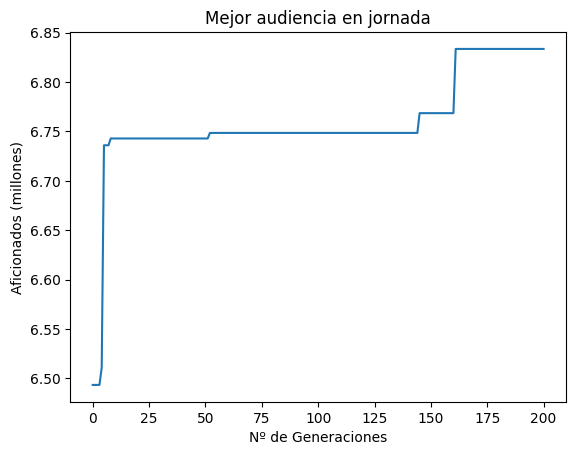

In [202]:
datos = [final[i][0] for i in range(len(final))]

import matplotlib.pyplot as plt

plt.plot(datos)
plt.xlabel('Nº de Generaciones')
plt.ylabel('Aficionados (millones)')
plt.title('Mejor audiencia en jornada')
plt.show()


In [201]:
print(f'Para la mejor jornada, tenemos los siguientes horarios: {final[-1][1]}')
print(f'La audiencia estimada es: {max(datos)} millones de espectadores.')
display(evaluation(final[-1][1])[1])

Para la mejor jornada, tenemos los siguientes horarios: ['S20', 'D18', 'L20', 'D20', 'V20', 'S16', 'S18', 'S12', 'D12', 'D16']
La audiencia estimada es: 6.8335 millones de espectadores.


,Partido,Categoría,Asistencia,Horario,Factor horario,Coincidencia,Factor coincidencia,Audiencia
0,Celta-RMadrid,BA,1.30,S20,1.00,0,1,1.3000
1,Valencia-RSociedad,BA,1.30,D18,0.85,0,1,1.1050
2,Mallorca-Eibar,CC,0.47,L20,0.40,0,1,0.1880
3,Athletic-Barcelona,BA,1.30,D20,1.00,0,1,1.3000
4,Leganés-Osasuna,CC,0.47,V20,0.40,0,1,0.1880
5,Villareal-Granada,BC,0.75,S16,0.70,0,1,0.5250
6,Alaves-Levante,BB,0.90,S18,0.80,0,1,0.7200
7,Espanyol-Sevilla,BB,0.90,S12,0.55,0,1,0.4950
8,Betis-Valladolid,BC,0.75,D12,0.45,0,1,0.3375
9,Atlético-Getafe,BB,0.90,D16,0.75,0,1,0.6750
